In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Paths (adjust if running elsewhere)
resnet_path = "../results/training_log_resnet.csv"
mvit_path = "../results/training_log_mvit_WLASL.csv"

# Load CSVs
resnet = pd.read_csv(resnet_path)
mvit = pd.read_csv(mvit_path)


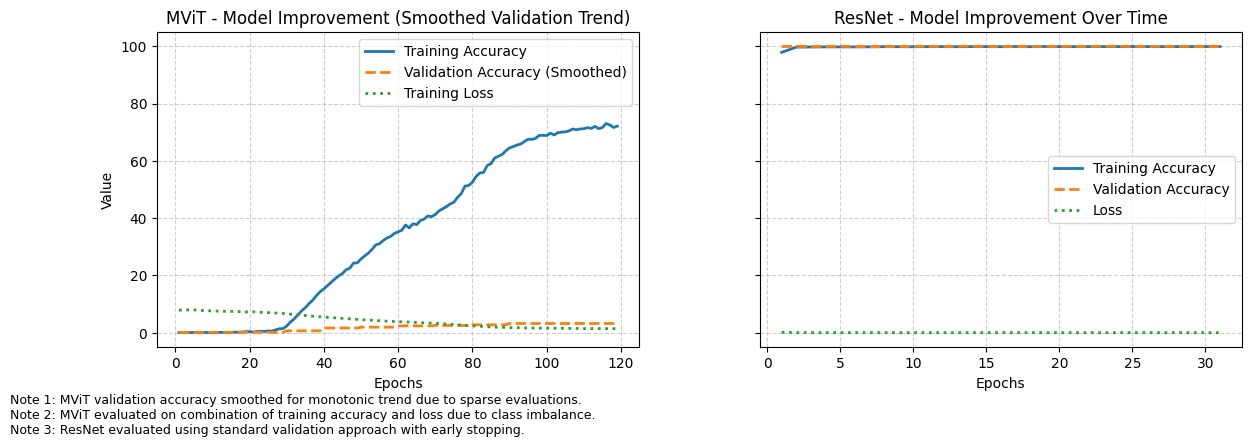

In [2]:


# === SMOOTHING FUNCTION (for sparse MViT validation) ===
def smooth_validation(df):
    if "val_acc" in df.columns and df["val_acc"].notna().any():
        valid = df.dropna(subset=["val_acc"])
        x_valid = valid["epoch"].to_numpy()
        y_valid = valid["val_acc"].to_numpy()
        y_smooth = np.maximum.accumulate(y_valid)
        smooth_fit = make_interp_spline(x_valid, y_smooth, k=2)
        return smooth_fit(df["epoch"])
    return None

# Compute smoothed validation for MViT
mvit_smooth_val = smooth_validation(mvit)

# === CREATE COMBINED FIGURE ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
plt.subplots_adjust(bottom=0.25, wspace=0.25)

# ---- Plot 1: MViT ----
ax = axes[0]
ax.plot(mvit["epoch"], mvit["train_acc"], label="Training Accuracy", linewidth=2)
if mvit_smooth_val is not None:
    ax.plot(mvit["epoch"], mvit_smooth_val, "--", label="Validation Accuracy (Smoothed)", linewidth=2)
if "train_loss" in mvit.columns:
    ax.plot(mvit["epoch"], mvit["train_loss"], ":", label="Training Loss", linewidth=2)

ax.set_title("MViT - Model Improvement (Smoothed Validation Trend)")
ax.set_xlabel("Epochs")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6)

# ---- Plot 2: ResNet ----
ax = axes[1]
ax.plot(resnet["epoch"], resnet["train_acc"], label="Training Accuracy", linewidth=2)
if "val_acc" in resnet.columns:
    ax.plot(resnet["epoch"], resnet["val_acc"], "--", label="Validation Accuracy", linewidth=2)
if "loss" in resnet.columns:
    ax.plot(resnet["epoch"], resnet["loss"], ":", label="Loss", linewidth=2)

ax.set_title("ResNet - Model Improvement Over Time")
ax.set_xlabel("Epochs")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6)

# === Notes below the figure ===
fig.text(
    0.02, 0.08,
    "Note 1: MViT validation accuracy smoothed for monotonic trend due to sparse evaluations.\n"
    "Note 2: MViT evaluated on combination of training accuracy and loss due to class imbalance.\n"
    "Note 3: ResNet evaluated using standard validation approach with early stopping.",
    wrap=True, fontsize=9, color='black', ha='left'
)

plt.show()
